In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import warnings

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

from scipy.stats import norm, skew
from scipy import stats

import seaborn as sns

import statsmodels.api as sm


pd.set_option('display.max_rows', 10)
%matplotlib inline

## Load Training Data

In [46]:
train_data = pd.read_csv('data/train.csv')
display(train_data)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


## Relationship between sale price and year of sale, garage area, lot area, and other variables

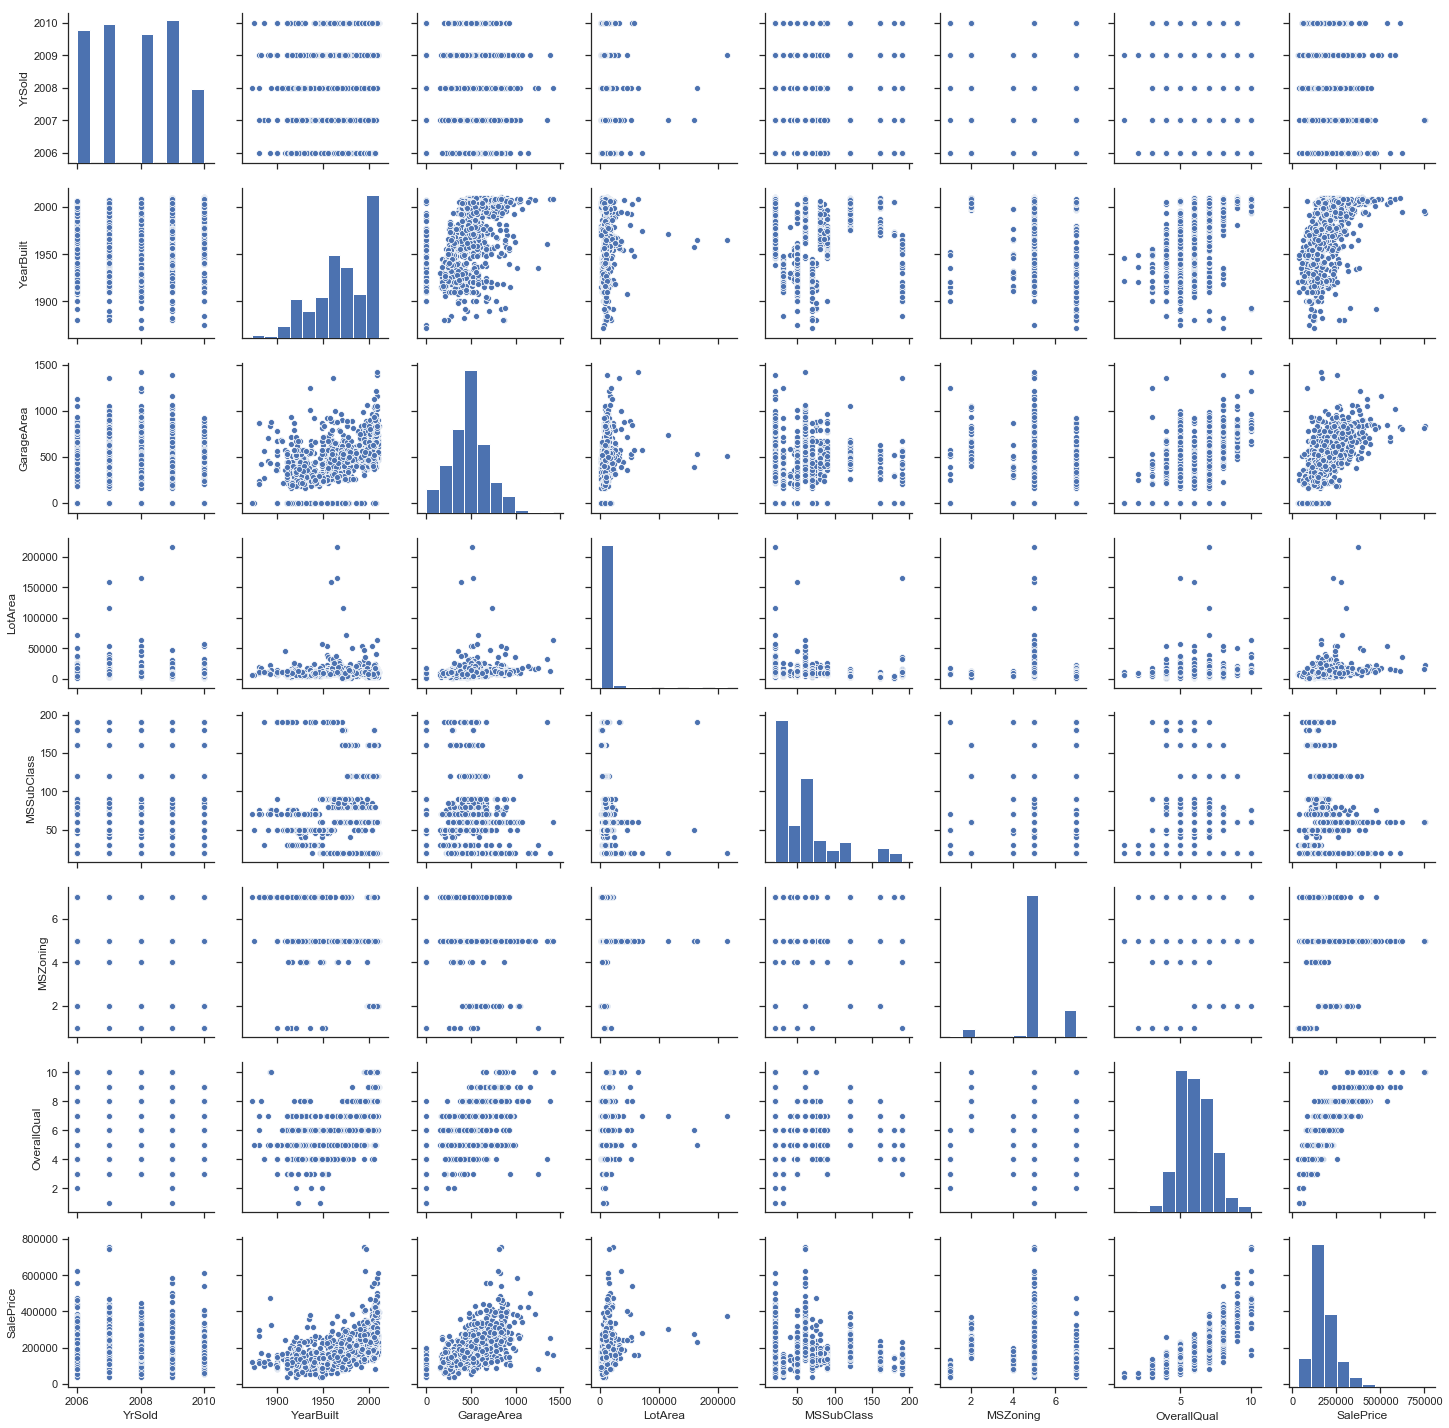

In [3]:
df = train_data.loc[:,['YrSold', 'YearBuilt', 'GarageArea', 'LotArea', 'MSSubClass', 'OverallQual', 'SalePrice']]
# display(df)

# 'MSZoning'
df.insert(5, 'MSZoning', (train_data['MSZoning'].map({'A':0, 'C (all)':1, 'FV':2, 'I':3, 'RH':4, 'RL':5, 'RP':6, 'RM':7}).astype(int)))
              
sns.set(style="ticks", color_codes=True)
sns.pairplot(df)

## Preprocessing

In [47]:
train_X = train_data.iloc[:, :80]
train_Y = train_data.iloc[:, 80]

# drop Id
train_X.drop(['Id'], axis =1, inplace=True)

# Check NAs and drop feature with too many NAs
train_NAs = train_X.isnull().sum()
train_NAs = train_NAs[train_NAs > 0]
train_NAs = train_NAs.sort_values(ascending=False)
display(train_NAs)

NA_drops = train_NAs[train_NAs > train_X.shape[0] * 0.33].index
print("NA drops:", NA_drops)
train_NAs.drop(NA_drops)
train_X.drop(NA_drops, axis = 1, inplace=True)

PoolQC         1453
MiscFeature    1406
Alley          1369
Fence          1179
FireplaceQu     690
               ... 
BsmtCond         37
BsmtQual         37
MasVnrArea        8
MasVnrType        8
Electrical        1
Length: 19, dtype: int64

NA drops: Index(['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu'], dtype='object')


#### Numerical Features

In [48]:
# Numerical Features
num_features = train_X.select_dtypes(exclude = ["object"]).columns
num_features = num_features.drop("MSSubClass")
print("Numerical Features:", num_features, len(num_features))

# Handle NAs in numerical features
print("-------------------------------------------------------------------------------------------------")
train_X_num = train_X[num_features]
print("NAs for numerical features in train_X : " + str(train_X_num.isnull().values.sum()))
train_X_num = train_X_num.fillna(train_X_num.median())
print("Remaining NAs for numerical features in train : " + str(train_X_num.isnull().values.sum()))
display(train_X_num)

Numerical Features: Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object') 35
-------------------------------------------------------------------------------------------------
NAs for numerical features in train_X : 348
Remaining NAs for numerical features in train : 0


,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,65.0,8450,7,5,2003,2003,196.0,706,0,150,...,548,0,61,0,0,0,0,0,2,2008
1,80.0,9600,6,8,1976,1976,0.0,978,0,284,...,460,298,0,0,0,0,0,0,5,2007
2,68.0,11250,7,5,2001,2002,162.0,486,0,434,...,608,0,42,0,0,0,0,0,9,2008
3,60.0,9550,7,5,1915,1970,0.0,216,0,540,...,642,0,35,272,0,0,0,0,2,2006
4,84.0,14260,8,5,2000,2000,350.0,655,0,490,...,836,192,84,0,0,0,0,0,12,2008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,62.0,7917,6,5,1999,2000,0.0,0,0,953,...,460,0,40,0,0,0,0,0,8,2007
1456,85.0,13175,6,6,1978,1988,119.0,790,163,589,...,500,349,0,0,0,0,0,0,2,2010
1457,66.0,9042,7,9,1941,2006,0.0,275,0,877,...,252,0,60,0,0,0,0,2500,5,2010
1458,68.0,9717,5,6,1950,1996,0.0,49,1029,0,...,240,366,0,112,0,0,0,0,4,2010


#### Categorical Features

In [49]:
# Categorical Features
cat_features = train_X.select_dtypes(include=['object']).columns
cat_features = cat_features.insert(0, 'MSSubClass')   # MSSubClass should be a categorical feature
print("Categorical Features:", cat_features, len(cat_features))

# One hot encoding for catorgical features
print("-------------------------------------------------------------------------------------------------")
print("One Hot Encoding")
train_X_cat = train_X[cat_features]
print("NAs for categorical features in train_X : " + str(train_X_cat.isnull().values.sum()))
train_X_cat = pd.get_dummies(train_X_cat)
print("Remaining NAs for numerical features in train : " + str(train_X_cat.isnull().values.sum()))
display(train_X_cat)

Categorical Features: Index(['MSSubClass', 'MSZoning', 'Street', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond',
       'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
       'KitchenQual', 'Functional', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition'],
      dtype='object') 39
-------------------------------------------------------------------------------------------------
One Hot Encoding
NAs for categorical features in train_X : 520
Remaining NAs for numerical features in train : 0


,MSSubClass,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,LotShape_IR1,LotShape_IR2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,0,0,0,1,0,0,1,0,0,...,0,0,0,1,0,0,0,0,1,0
1,20,0,0,0,1,0,0,1,0,0,...,0,0,0,1,0,0,0,0,1,0
2,60,0,0,0,1,0,0,1,1,0,...,0,0,0,1,0,0,0,0,1,0
3,70,0,0,0,1,0,0,1,1,0,...,0,0,0,1,1,0,0,0,0,0
4,60,0,0,0,1,0,0,1,1,0,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,0,0,0,1,0,0,1,0,0,...,0,0,0,1,0,0,0,0,1,0
1456,20,0,0,0,1,0,0,1,0,0,...,0,0,0,1,0,0,0,0,1,0
1457,70,0,0,0,1,0,0,1,0,0,...,0,0,0,1,0,0,0,0,1,0
1458,20,0,0,0,1,0,0,1,0,0,...,0,0,0,1,0,0,0,0,1,0


#### Check Skewness

In [50]:
# skewness = train_X_num.apply(lambda x: skew(x)).sort_values(ascending=False)
# skewness = skewness[abs(skewness) > 0.5]
# skewness.index

# skew_features = train_X_num[skewness.index]
# skew_features = np.log1p(skew_features)
# train_X_num.update(skew_features)
# print(skew_features.columns)

#### Concat training data

In [51]:
# Concat train_X
print("train_X_num:", train_X_num.shape, "train_X_cat:", train_X_cat.shape)
train_X_combi = pd.concat([train_X_num, train_X_cat], axis=1, join='outer', join_axes=None, ignore_index=False, keys=None, levels=None, names=None, verify_integrity=False, copy=True)
print("train_X_combin:", train_X_combi.shape)
display(train_X_combi)

train_X_num: (1460, 35) train_X_cat: (1460, 235)
train_X_combin: (1460, 270)


,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,65.0,8450,7,5,2003,2003,196.0,706,0,150,...,0,0,0,1,0,0,0,0,1,0
1,80.0,9600,6,8,1976,1976,0.0,978,0,284,...,0,0,0,1,0,0,0,0,1,0
2,68.0,11250,7,5,2001,2002,162.0,486,0,434,...,0,0,0,1,0,0,0,0,1,0
3,60.0,9550,7,5,1915,1970,0.0,216,0,540,...,0,0,0,1,1,0,0,0,0,0
4,84.0,14260,8,5,2000,2000,350.0,655,0,490,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,62.0,7917,6,5,1999,2000,0.0,0,0,953,...,0,0,0,1,0,0,0,0,1,0
1456,85.0,13175,6,6,1978,1988,119.0,790,163,589,...,0,0,0,1,0,0,0,0,1,0
1457,66.0,9042,7,9,1941,2006,0.0,275,0,877,...,0,0,0,1,0,0,0,0,1,0
1458,68.0,9717,5,6,1950,1996,0.0,49,1029,0,...,0,0,0,1,0,0,0,0,1,0


## Run OLS (ordinary Least squares) on all the features

In [9]:
res = sm.OLS(train_Y, sm.add_constant(train_X_combi)).fit()
print(res.summary())
conf_int = res.conf_int()
contains_zero = conf_int[(conf_int[0] <= 0) & (conf_int[1] >= 0)]
not_contains_zero = conf_int.drop(contains_zero.index)
print(conf_int.shape, contains_zero.shape, not_contains_zero.shape)
display("confidence interval contains zero:", contains_zero.index, len(contains_zero))
display("confidence interval not contains zero:", not_contains_zero.index, len(not_contains_zero))

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.931
Model:                            OLS   Adj. R-squared:                  0.918
Method:                 Least Squares   F-statistic:                     70.31
Date:                Wed, 03 Oct 2018   Prob (F-statistic):               0.00
Time:                        00:30:48   Log-Likelihood:                -16592.
No. Observations:                1460   AIC:                         3.366e+04
Df Residuals:                    1224   BIC:                         3.490e+04
Df Model:                         235                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                 -1.117e+

'confidence interval contains zero:'

Index(['const', 'LotFrontage', 'YearRemodAdd', 'BsmtFinSF2', 'BsmtUnfSF',
       'LowQualFinSF', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       ...
       'SaleType_ConLw', 'SaleType_New', 'SaleType_Oth', 'SaleType_WD',
       'SaleCondition_Abnorml', 'SaleCondition_AdjLand',
       'SaleCondition_Alloca', 'SaleCondition_Family', 'SaleCondition_Normal',
       'SaleCondition_Partial'],
      dtype='object', length=227)

227

'confidence interval not contains zero:'

Index(['LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'MasVnrArea',
       'BsmtFinSF1', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea',
       'BedroomAbvGr', 'KitchenAbvGr', 'GarageArea', 'WoodDeckSF',
       'ScreenPorch', 'PoolArea', 'Neighborhood_Crawfor',
       'Neighborhood_Edwards', 'Neighborhood_Mitchel', 'Neighborhood_NAmes',
       'Neighborhood_NWAmes', 'Neighborhood_NoRidge', 'Neighborhood_NridgHt',
       'Neighborhood_StoneBr', 'Condition2_PosA', 'Condition2_PosN',
       'Condition2_RRAe', 'RoofMatl_ClyTile', 'RoofMatl_CompShg',
       'RoofMatl_Membran', 'RoofMatl_Metal', 'RoofMatl_Tar&Grv',
       'RoofMatl_WdShake', 'RoofMatl_WdShngl', 'GarageType_2Types',
       'GarageFinish_RFn', 'GarageQual_Ex', 'GarageQual_Fa', 'GarageQual_Gd',
       'GarageQual_Po', 'GarageQual_TA', 'GarageCond_Ex', 'GarageCond_Fa',
       'GarageCond_TA'],
      dtype='object')

44

## Normalize data

In [52]:
scaler = StandardScaler().fit(train_X_num)
train_X_norm = pd.DataFrame(data=scaler.transform(train_X_num), columns=train_X_num.columns)
train_X_norm = pd.concat([train_X_norm, train_X_cat], axis=1, join='outer', join_axes=None, ignore_index=False, keys=None, levels=None, names=None, verify_integrity=False, copy=True)
display(train_X_norm)

print(train_X_norm.shape)
print(train_Y.shape)

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,-0.220875,-0.207142,0.651479,-0.517200,1.050994,0.878668,0.514104,0.575425,-0.288653,-0.944591,...,0,0,0,1,0,0,0,0,1,0
1,0.460320,-0.091886,-0.071836,2.179628,0.156734,-0.429577,-0.570750,1.171992,-0.288653,-0.641228,...,0,0,0,1,0,0,0,0,1,0
2,-0.084636,0.073480,0.651479,-0.517200,0.984752,0.830215,0.325915,0.092907,-0.288653,-0.301643,...,0,0,0,1,0,0,0,0,1,0
3,-0.447940,-0.096897,0.651479,-0.517200,-1.863632,-0.720298,-0.570750,-0.499274,-0.288653,-0.061670,...,0,0,0,1,1,0,0,0,0,0
4,0.641972,0.375148,1.374795,-0.517200,0.951632,0.733308,1.366489,0.463568,-0.288653,-0.174865,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,-0.357114,-0.260560,-0.071836,-0.517200,0.918511,0.733308,-0.570750,-0.973018,-0.288653,0.873321,...,0,0,0,1,0,0,0,0,1,0
1456,0.687385,0.266407,-0.071836,0.381743,0.222975,0.151865,0.087911,0.759659,0.722112,0.049262,...,0,0,0,1,0,0,0,0,1,0
1457,-0.175462,-0.147810,0.651479,3.078570,-1.002492,1.024029,-0.570750,-0.369871,-0.288653,0.701265,...,0,0,0,1,0,0,0,0,1,0
1458,-0.084636,-0.080160,-0.795151,0.381743,-0.704406,0.539493,-0.570750,-0.865548,6.092188,-1.284176,...,0,0,0,1,0,0,0,0,1,0


(1460, 270)
(1460,)


##  Cross Validation (Train: 80%, Test: 20%)

In [53]:
x_train, x_test, y_train, y_test = train_test_split(train_X_norm, train_Y, test_size=0.2, random_state=42)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(1168, 270) (292, 270) (1168,) (292,)


#### OLS

In [13]:
clf = LinearRegression()
clf.fit(x_train, y_train)
scores = clf.score(x_test, y_test)
print("OLS: R2 Score: %f" % (scores.mean()))

OLS: R2 Score: 0.885681


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/base.py:509: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


#### KNN

In [148]:
def kNN(k_range, x_train, x_test, y_train, y_test):
    scores = []
    for k in k_range:
        clf = KNeighborsRegressor(n_neighbors=k)
        score = cross_val_score(clf, x_train, y_train, cv=10, scoring='r2')
        print("kNN(" + str(k) + "): R2: %f (+/- %0.2f)" % (score.mean(), score.std() * 2)) 
        scores.append(score.mean())

    scores = np.array(scores)
    optimal_k = scores.argmax() + k_range[0]
    print("Optimal K=" + str(optimal_k), "with R2 Score:", scores[optimal_k - k_range[0]]) 

    plt.plot(k_range, scores)
    plt.xlabel('$k$')
    plt.ylabel('$R2 Score$')
    plt.show()
    
    clf = KNeighborsRegressor(n_neighbors=optimal_k)
    clf.fit(x_train, y_train)
    score = clf.score(x_test, y_test)
    print("kNN: Optimal K = %d,  R2 Score = %f" % (optimal_k, score))

kNN(1): R2: 0.577557 (+/- 0.43)
kNN(2): R2: 0.704329 (+/- 0.17)
kNN(3): R2: 0.727208 (+/- 0.16)
kNN(4): R2: 0.738640 (+/- 0.15)
kNN(5): R2: 0.741662 (+/- 0.14)
kNN(6): R2: 0.749496 (+/- 0.13)
kNN(7): R2: 0.747457 (+/- 0.12)
kNN(8): R2: 0.748356 (+/- 0.11)
kNN(9): R2: 0.741685 (+/- 0.11)
kNN(10): R2: 0.738949 (+/- 0.11)
kNN(11): R2: 0.735456 (+/- 0.11)
kNN(12): R2: 0.734242 (+/- 0.11)
kNN(13): R2: 0.731769 (+/- 0.10)
kNN(14): R2: 0.729523 (+/- 0.10)
kNN(15): R2: 0.727858 (+/- 0.10)
kNN(16): R2: 0.727586 (+/- 0.10)
kNN(17): R2: 0.725744 (+/- 0.10)
kNN(18): R2: 0.723896 (+/- 0.10)
kNN(19): R2: 0.720620 (+/- 0.10)
kNN(20): R2: 0.719718 (+/- 0.10)
kNN(21): R2: 0.719421 (+/- 0.10)
kNN(22): R2: 0.716569 (+/- 0.10)
kNN(23): R2: 0.712864 (+/- 0.10)
kNN(24): R2: 0.708830 (+/- 0.10)
kNN(25): R2: 0.707088 (+/- 0.10)
kNN(26): R2: 0.701957 (+/- 0.09)
kNN(27): R2: 0.699405 (+/- 0.09)
kNN(28): R2: 0.696838 (+/- 0.09)
kNN(29): R2: 0.692548 (+/- 0.09)
kNN(30): R2: 0.690544 (+/- 0.09)
kNN(31): R2: 0.6877

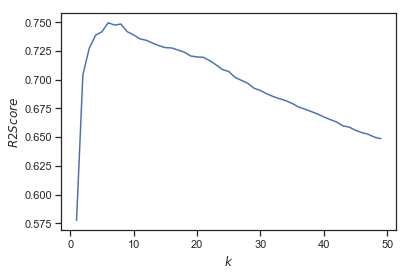

kNN: Optimal K = 6,  R2 Score = 0.786484
CPU times: user 14.2 s, sys: 221 ms, total: 14.5 s
Wall time: 14 s


In [149]:
%%time

warnings.filterwarnings('ignore')

kNN(range(1, 50), x_train, x_test, y_train, y_test)

warnings.filterwarnings('default')

#### Ridge Regression

In [14]:
def ridge_reg(alphas, x_train, x_test, y_train, y_test):
    clf = RidgeCV(alphas=alphas, cv=10).fit(x_train, y_train)
    print("1st round R2 score %6f" % (clf.score(x_train, y_train)))
    print("1st round best alpha :", clf.alpha_)

    alpha = [clf.alpha_ * i/10 for i in range(5, 51, )]
    clf = RidgeCV(alphas=alpha, cv=10).fit(x_train, y_train)
    print("2nd round R2 score %6f" % (clf.score(x_train, y_train)))
    print("2nd round best alpha :", clf.alpha_)
    
    best_alpha = clf.alpha_
    coef = pd.Series(clf.coef_, index = x_train.columns)
    print("Ridge picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")
    display("Retained: " + str(coef[coef!=0].shape), coef[coef!=0].index)
    display("Eliminated: " + str(coef[coef==0].shape), coef[coef==0].index)

    clf = Ridge(alpha=best_alpha).fit(x_train, y_train)
    score = clf.score(x_test, y_test)
    print("Ridge: Best Alpha = %f, R2 Score = %f" % (best_alpha, score))

In [15]:
%%time

ridge_reg([0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000, 1000000, 10000000], 
          x_train, x_test, y_train, y_test)


1st round R2 score 0.896949
1st round best alpha : 10
2nd round R2 score 0.889731
2nd round best alpha : 20.0
Ridge picked 268 variables and eliminated the other 2 variables


'Retained: (268,)'

Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       ...
       'SaleType_ConLw', 'SaleType_New', 'SaleType_Oth', 'SaleType_WD',
       'SaleCondition_Abnorml', 'SaleCondition_AdjLand',
       'SaleCondition_Alloca', 'SaleCondition_Family', 'SaleCondition_Normal',
       'SaleCondition_Partial'],
      dtype='object', length=268)

'Eliminated: (2,)'

Index(['RoofMatl_Membran', 'Electrical_Mix'], dtype='object')

Ridge: Best Alpha = 20.000000, R2 Score = 0.876353
CPU times: user 27.2 s, sys: 6.74 s, total: 34 s
Wall time: 8.67 s


#### LASSO

In [24]:
def Lasso_reg(alphas, x_train, x_test, y_train, y_test):
    clf = LassoCV(alphas=alphas, cv=10).fit(x_train, y_train)
    print("1st round R2 score %6f" % (clf.score(x_train, y_train)))
    print("1st round best alpha :", clf.alpha_)

    alpha = [clf.alpha_ * i/10 for i in range(5, 51, 5)]
    clf = LassoCV(alphas=alpha, cv=10).fit(x_train, y_train)
    print("2nd round R2 score %6f" % (clf.score(x_train, y_train)))
    print("2nd round best alpha :", clf.alpha_)

    best_alpha = clf.alpha_
    coef = pd.Series(clf.coef_, index = x_train.columns)
    print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")
    display("Retained: " + str(coef[coef!=0].shape), coef[coef!=0].index)
    display("Eliminated: " + str(coef[coef==0].shape), coef[coef==0].index)

    clf = Lasso(alpha=best_alpha).fit(x_train, y_train)
    score = clf.score(x_test, y_test)
    print("Lasso: Best Alpha = %f, R2 Score = %f" % (best_alpha, score))

In [25]:
%%time

warnings.filterwarnings('ignore')

Lasso_reg([0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000, 1000000, 10000000],
          x_train, x_test, y_train, y_test)

warnings.filterwarnings('default')

1st round R2 score 0.917504
1st round best alpha : 100.0
2nd round R2 score 0.908469
2nd round best alpha : 150.0
Lasso picked 90 variables and eliminated the other 180 variables


'Retained: (90,)'

Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'TotalBsmtSF',
       '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath',
       'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'MSSubClass', 'MSZoning_RM', 'LotShape_IR2',
       'LandContour_Bnk', 'LandContour_HLS', 'LotConfig_CulDSac',
       'LotConfig_FR2', 'LandSlope_Mod', 'Neighborhood_BrkSide',
       'Neighborhood_Crawfor', 'Neighborhood_Edwards', 'Neighborhood_Gilbert',
       'Neighborhood_Mitchel', 'Neighborhood_NAmes', 'Neighborhood_NWAmes',
       'Neighborhood_NoRidge', 'Neighborhood_NridgHt', 'Neighborhood_OldTown',
       'Neighborhood_Somerst', 'Neighborhood_StoneBr', 'Condition1_Norm',
       'Condition2_PosN', 'BldgTy

'Eliminated: (180,)'

Index(['BsmtUnfSF', '1stFlrSF', 'EnclosedPorch', 'YrSold', 'MSZoning_C (all)',
       'MSZoning_FV', 'MSZoning_RH', 'MSZoning_RL', 'Street_Grvl',
       'Street_Pave',
       ...
       'SaleType_Con', 'SaleType_ConLD', 'SaleType_ConLI', 'SaleType_ConLw',
       'SaleType_New', 'SaleType_Oth', 'SaleCondition_AdjLand',
       'SaleCondition_Alloca', 'SaleCondition_Family', 'SaleCondition_Normal'],
      dtype='object', length=180)

Lasso: Best Alpha = 150.000000, R2 Score = 0.890518
CPU times: user 12.8 s, sys: 3.34 s, total: 16.2 s
Wall time: 4.37 s


#### Backward Stepwise - Using RFE from scikit-learn

In [162]:
%%time

cls = LinearRegression()
rfecv = RFECV(estimator=cls, step=1, cv=10)
rfecv.fit(x_train, y_train)
score = rfecv.score(x_train, y_train)
print("Backward stepwise cross validation: R2 score: %f" % (score))

picked = x_train.columns[rfecv.support_]
unpicked = x_train.columns[~rfecv.support_]
print("Backward stepwise picked " + str(len(picked)) + " variables and eliminated the other " +  str(len(unpicked)) + " variables")
display("Selected: " + str(len(picked)), picked)
display("Eliminated: " + str(len(unpicked)), unpicked)

clf = LinearRegression().fit(x_train, y_train)
score = clf.score(x_test, y_test)
print("Backward stepwise: R2 score before elimanating: %f" % (score))

clf = LinearRegression().fit(x_train.loc[: , picked], y_train)
score = clf.score(x_test.loc[: , picked], y_test)
print("Backward stepwise: R2 score after elimanating: %f" % (score))

Backward stepwise cross validation: R2 score: 0.929005
Backward stepwise picked 163 variables and eliminated the other 107 variables


'Selected: 163'

Index(['LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'BsmtFinSF1',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'GarageArea',
       ...
       'SaleType_CWD', 'SaleType_Con', 'SaleType_ConLD', 'SaleType_ConLI',
       'SaleType_Oth', 'SaleType_WD', 'SaleCondition_Abnorml',
       'SaleCondition_Alloca', 'SaleCondition_Family', 'SaleCondition_Normal'],
      dtype='object', length=163)

'Eliminated: 107'

Index(['LotFrontage', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF2', 'BsmtUnfSF',
       'LowQualFinSF', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       ...
       'GarageType_Basment', 'GarageType_BuiltIn', 'GarageType_Detchd',
       'PavedDrive_N', 'PavedDrive_P', 'PavedDrive_Y', 'SaleType_ConLw',
       'SaleType_New', 'SaleCondition_AdjLand', 'SaleCondition_Partial'],
      dtype='object', length=107)

Backward stepwise: R2 score before elimanating: 0.885681
Backward stepwise: R2 score after elimanating: 0.875894
CPU times: user 3min 31s, sys: 58.5 s, total: 4min 30s
Wall time: 1min 9s


#### Backward Stepwise

In [156]:
def backward_stepwise(k, x_train, y_train, x_test, y_test):
    feature_left = x_train.columns
    unselected = []
    n = len(feature_left)
    scores = []
    
    while n - len(feature_left) < k:
        model = sm.OLS(y_train, sm.add_constant(x_train.loc[:, feature_left])).fit()
        worst_feature = model.pvalues.drop('const').idxmax()
        feature_left = feature_left.drop(worst_feature)
        unselected.append(worst_feature)
        
        # cross validation
        clf = LinearRegression()
        clf.fit(x_train.loc[:, feature_left], y_train)
        score = cross_val_score(clf, x_train.loc[:, feature_left], y_train, cv=10, scoring='r2')
        scores.append(score.mean())
        
        print("Backward Stepwise(%d): Score: %f" % (len(feature_left), score.mean()))
        

    scores = np.array(scores)
    optimal_k = scores.argmax() + 1

    selected = list(set(x_train.columns) - set(unselected[:optimal_k]))
    print("Optimal K=" + str(optimal_k), "with R2 Score:", scores[optimal_k - 1]) 
    print("Selected Features:", len(selected), selected)

    plt.plot(range(1, k + 1), scores)
    plt.xlabel('$k$')
    plt.ylabel('$R2-Score$')
    plt.ylim((0, 1))
    plt.show()

    clf = LinearRegression().fit(x_train, y_train)
    score = clf.score(x_test, y_test)
    print("Backward stepwise: Score before selection: %f" % (score))

    clf = LinearRegression().fit(x_train.loc[: , selected], y_train)
    score = clf.score(x_test.loc[: , selected], y_test)
    print("Backward stepwise: Score after selection: %f" % (score))

Backward Stepwise(269): Score: 0.758185
Backward Stepwise(268): Score: 0.758185
Backward Stepwise(267): Score: 0.758343
Backward Stepwise(266): Score: 0.758349
Backward Stepwise(265): Score: 0.758349
Backward Stepwise(264): Score: 0.758692
Backward Stepwise(263): Score: 0.758727
Backward Stepwise(262): Score: 0.758874
Backward Stepwise(261): Score: 0.758878
Backward Stepwise(260): Score: 0.758878
Backward Stepwise(259): Score: 0.758878
Backward Stepwise(258): Score: 0.759163
Backward Stepwise(257): Score: 0.759282
Backward Stepwise(256): Score: 0.759282
Backward Stepwise(255): Score: 0.759787
Backward Stepwise(254): Score: 0.759917
Backward Stepwise(253): Score: 0.759948
Backward Stepwise(252): Score: 0.760349
Backward Stepwise(251): Score: 0.760454
Backward Stepwise(250): Score: 0.760454
Backward Stepwise(249): Score: 0.760493
Backward Stepwise(248): Score: 0.760620
Backward Stepwise(247): Score: 0.760796
Backward Stepwise(246): Score: 0.761531
Backward Stepwise(245): Score: 0.761536


Backward Stepwise(65): Score: 0.759183
Backward Stepwise(64): Score: 0.757747
Backward Stepwise(63): Score: 0.759061
Backward Stepwise(62): Score: 0.759636
Backward Stepwise(61): Score: 0.757428
Backward Stepwise(60): Score: 0.755506
Backward Stepwise(59): Score: 0.755185
Backward Stepwise(58): Score: 0.757000
Backward Stepwise(57): Score: 0.758720
Backward Stepwise(56): Score: 0.757516
Backward Stepwise(55): Score: 0.755721
Backward Stepwise(54): Score: 0.755807
Backward Stepwise(53): Score: 0.755742
Backward Stepwise(52): Score: 0.755498
Backward Stepwise(51): Score: 0.754569
Backward Stepwise(50): Score: 0.753599
Backward Stepwise(49): Score: 0.749444
Backward Stepwise(48): Score: 0.750135
Backward Stepwise(47): Score: 0.747361
Backward Stepwise(46): Score: 0.747241
Backward Stepwise(45): Score: 0.746911
Backward Stepwise(44): Score: 0.749936
Backward Stepwise(43): Score: 0.749606
Backward Stepwise(42): Score: 0.747658
Backward Stepwise(41): Score: 0.747806
Backward Stepwise(40): Sc

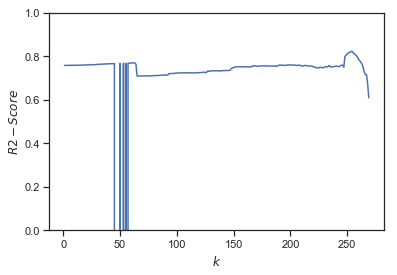

Backward stepwise: Score before selection: 0.885681
Backward stepwise: Score after selection: 0.887403
CPU times: user 6min 10s, sys: 1min 52s, total: 8min 3s
Wall time: 2min 5s


In [157]:
%%time

warnings.filterwarnings('ignore')

backward_stepwise(x_train.shape[1] - 1, x_train, y_train, x_test, y_test)

warnings.filterwarnings('default')

#### Forward Stepwise

In [19]:
def forward_stepwise(k, x_train, y_train, x_test, y_test):
    scores = []
    selected = []
    features_left = x_train.columns
    while len(selected) < k:
        new_pvals = pd.Series(index=features_left)
        for col in features_left:
            model = sm.OLS(y_train, sm.add_constant(pd.DataFrame(x_train[selected + [col]]))).fit()
            new_pvals[col] = model.pvalues[col]

        best_feature = new_pvals.idxmin()
        selected.append(best_feature)
        features_left = features_left.drop(best_feature)

        # cross validation
        clf = LinearRegression()
        score = cross_val_score(clf, x_train.loc[:, selected], y_train, cv=10, scoring='r2')
        scores.append(score.mean())
        
        print("Forward Stepwise(%d): Score: %f" % (len(selected), score.mean()))
        
        
    # wrap up
    scores = np.array(scores)
    optimal_k = scores.argmax() + 1
    print("Optimal K=" + str(optimal_k), "with R2 Score:", scores[optimal_k - 1]) 
    print("Selected Features:", selected[:optimal_k])
    plt.plot(range(1, k + 1), scores)
    plt.xlabel('$k$')
    plt.ylabel('$R2-Score$')
    plt.show()

    clf = LinearRegression().fit(x_train, y_train)
    score = clf.score(x_test, y_test)
    print("Forward stepwise: Score before selection: %f" % (score))

    clf = LinearRegression().fit(x_train.loc[: , selected[:optimal_k]], y_train)
    score = clf.score(x_test.loc[: , selected[:optimal_k]], y_test)
    print("Forward stepwise: Score after selection: %f" % (score))    


Forward Stepwise(1): Score: 0.609418
Forward Stepwise(2): Score: 0.694184
Forward Stepwise(3): Score: 0.728314
Forward Stepwise(4): Score: 0.727834
Forward Stepwise(5): Score: 0.743156
Forward Stepwise(6): Score: 0.761335
Forward Stepwise(7): Score: 0.774728
Forward Stepwise(8): Score: 0.748536
Forward Stepwise(9): Score: 0.757798
Forward Stepwise(10): Score: 0.762276
Forward Stepwise(11): Score: 0.767833
Forward Stepwise(12): Score: 0.765518
Forward Stepwise(13): Score: 0.765220
Forward Stepwise(14): Score: 0.776429
Forward Stepwise(15): Score: 0.777497
Forward Stepwise(16): Score: 0.784500
Forward Stepwise(17): Score: 0.789597
Forward Stepwise(18): Score: 0.793996
Forward Stepwise(19): Score: 0.802312
Forward Stepwise(20): Score: 0.801537
Forward Stepwise(21): Score: 0.799999
Forward Stepwise(22): Score: 0.803258
Forward Stepwise(23): Score: 0.795082
Forward Stepwise(24): Score: 0.796243
Forward Stepwise(25): Score: 0.791910
Forward Stepwise(26): Score: 0.791798
Forward Stepwise(27):

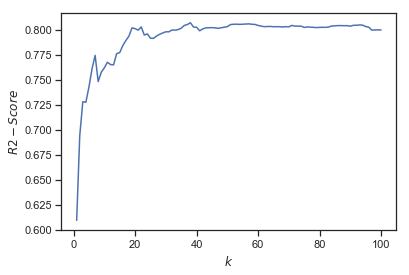

Forward stepwise: Score before selection: 0.885681
Forward stepwise: Score after selection: 0.902841
CPU times: user 41min 34s, sys: 12min 42s, total: 54min 17s
Wall time: 15min 15s


In [20]:
%%time

warnings.filterwarnings('ignore')

forward_stepwise(100, x_train, y_train, x_test, y_test)

warnings.filterwarnings('default')

## Quadratic Features

In [94]:
poly = PolynomialFeatures(2)
res = poly.fit_transform(train_X_norm)
names = poly.get_feature_names(train_X_norm.columns)
train_X_quad = pd.DataFrame(data=res, columns=names)
display(train_X_quad)

,1,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleCondition_Alloca^2,SaleCondition_Alloca SaleCondition_Family,SaleCondition_Alloca SaleCondition_Normal,SaleCondition_Alloca SaleCondition_Partial,SaleCondition_Family^2,SaleCondition_Family SaleCondition_Normal,SaleCondition_Family SaleCondition_Partial,SaleCondition_Normal^2,SaleCondition_Normal SaleCondition_Partial,SaleCondition_Partial^2
0,1.0,-0.220875,-0.207142,0.651479,-0.517200,1.050994,0.878668,0.514104,0.575425,-0.288653,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.0,0.460320,-0.091886,-0.071836,2.179628,0.156734,-0.429577,-0.570750,1.171992,-0.288653,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1.0,-0.084636,0.073480,0.651479,-0.517200,0.984752,0.830215,0.325915,0.092907,-0.288653,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1.0,-0.447940,-0.096897,0.651479,-0.517200,-1.863632,-0.720298,-0.570750,-0.499274,-0.288653,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.641972,0.375148,1.374795,-0.517200,0.951632,0.733308,1.366489,0.463568,-0.288653,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1.0,-0.357114,-0.260560,-0.071836,-0.517200,0.918511,0.733308,-0.570750,-0.973018,-0.288653,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1456,1.0,0.687385,0.266407,-0.071836,0.381743,0.222975,0.151865,0.087911,0.759659,0.722112,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1457,1.0,-0.175462,-0.147810,0.651479,3.078570,-1.002492,1.024029,-0.570750,-0.369871,-0.288653,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1458,1.0,-0.084636,-0.080160,-0.795151,0.381743,-0.704406,0.539493,-0.570750,-0.865548,6.092188,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


##  Cross Validation for Quadratic (Train: 80%, Test: 20%)

In [161]:
x_train_q, x_test_q, y_train_q, y_test_q = train_test_split(train_X_quad, train_Y, test_size=0.2, random_state=42)
print(x_train_q.shape, x_test_q.shape, y_train_q.shape, y_test_q.shape)

(1168, 38226) (292, 38226) (1168,) (292,)


#### kNN

kNN(1): R2: 0.579846 (+/- 0.43)
kNN(2): R2: 0.708643 (+/- 0.18)
kNN(3): R2: 0.726367 (+/- 0.17)
kNN(4): R2: 0.737110 (+/- 0.15)
kNN(5): R2: 0.740229 (+/- 0.14)
kNN(6): R2: 0.740023 (+/- 0.14)
kNN(7): R2: 0.738152 (+/- 0.13)
kNN(8): R2: 0.736863 (+/- 0.10)
kNN(9): R2: 0.736071 (+/- 0.11)
kNN(10): R2: 0.731472 (+/- 0.10)
kNN(11): R2: 0.729160 (+/- 0.10)
kNN(12): R2: 0.722301 (+/- 0.10)
kNN(13): R2: 0.721630 (+/- 0.11)
kNN(14): R2: 0.718870 (+/- 0.10)
kNN(15): R2: 0.720884 (+/- 0.11)
kNN(16): R2: 0.720269 (+/- 0.11)
kNN(17): R2: 0.718248 (+/- 0.10)
kNN(18): R2: 0.717560 (+/- 0.10)
kNN(19): R2: 0.714678 (+/- 0.10)
kNN(20): R2: 0.714967 (+/- 0.10)
kNN(21): R2: 0.712820 (+/- 0.10)
kNN(22): R2: 0.709633 (+/- 0.10)
kNN(23): R2: 0.705902 (+/- 0.10)
kNN(24): R2: 0.702886 (+/- 0.10)
kNN(25): R2: 0.699432 (+/- 0.10)
kNN(26): R2: 0.695926 (+/- 0.10)
kNN(27): R2: 0.694207 (+/- 0.10)
kNN(28): R2: 0.690907 (+/- 0.10)
kNN(29): R2: 0.688123 (+/- 0.10)
kNN(30): R2: 0.686282 (+/- 0.10)
kNN(31): R2: 0.6825

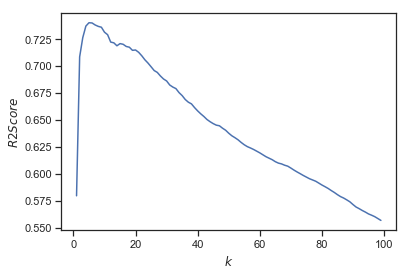

kNN: Optimal K = 5,  R2 Score = 0.789874
CPU times: user 1h 10min 3s, sys: 3min 7s, total: 1h 13min 10s
Wall time: 1h 13min 26s


In [96]:
%%time

kNN(range(1, 50), x_train_q, x_test_q, y_train_q, y_test_q)

#### Ridge

In [160]:
%%time

ridge_reg([0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000, 1000000], 
          x_train_q, x_test_q, y_train_q, y_test_q)

1st round R2 score 0.896949
1st round best alpha : 10
2nd round R2 score 0.889731
2nd round best alpha : 20.0
Ridge picked 268 variables and eliminated the other 2 variables


'Retained: (268,)'

Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       ...
       'SaleType_ConLw', 'SaleType_New', 'SaleType_Oth', 'SaleType_WD',
       'SaleCondition_Abnorml', 'SaleCondition_AdjLand',
       'SaleCondition_Alloca', 'SaleCondition_Family', 'SaleCondition_Normal',
       'SaleCondition_Partial'],
      dtype='object', length=268)

'Eliminated: (2,)'

Index(['RoofMatl_Membran', 'Electrical_Mix'], dtype='object')

Ridge: Best Alpha = 20.000000, R2 Score = 0.876353
CPU times: user 22.8 s, sys: 4.32 s, total: 27.1 s
Wall time: 6.57 s


#### LASSO

In [159]:
%%time

warnings.filterwarnings('ignore')

Lasso_reg([0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000, 1000000, 10000000],
          x_train_q, x_test_q, y_train_q, y_test_q)

warnings.filterwarnings('default')

1st round R2 score 0.917504
1st round best alpha : 100.0
2nd round R2 score 0.908469
2nd round best alpha : 150.0
Lasso picked 90 variables and eliminated the other 180 variables


'Retained: (90,)'

Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'TotalBsmtSF',
       '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath',
       'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'MSSubClass', 'MSZoning_RM', 'LotShape_IR2',
       'LandContour_Bnk', 'LandContour_HLS', 'LotConfig_CulDSac',
       'LotConfig_FR2', 'LandSlope_Mod', 'Neighborhood_BrkSide',
       'Neighborhood_Crawfor', 'Neighborhood_Edwards', 'Neighborhood_Gilbert',
       'Neighborhood_Mitchel', 'Neighborhood_NAmes', 'Neighborhood_NWAmes',
       'Neighborhood_NoRidge', 'Neighborhood_NridgHt', 'Neighborhood_OldTown',
       'Neighborhood_Somerst', 'Neighborhood_StoneBr', 'Condition1_Norm',
       'Condition2_PosN', 'BldgTy

'Eliminated: (180,)'

Index(['BsmtUnfSF', '1stFlrSF', 'EnclosedPorch', 'YrSold', 'MSZoning_C (all)',
       'MSZoning_FV', 'MSZoning_RH', 'MSZoning_RL', 'Street_Grvl',
       'Street_Pave',
       ...
       'SaleType_Con', 'SaleType_ConLD', 'SaleType_ConLI', 'SaleType_ConLw',
       'SaleType_New', 'SaleType_Oth', 'SaleCondition_AdjLand',
       'SaleCondition_Alloca', 'SaleCondition_Family', 'SaleCondition_Normal'],
      dtype='object', length=180)

Lasso: Best Alpha = 150.000000, R2 Score = 0.890518
CPU times: user 11.5 s, sys: 2.64 s, total: 14.2 s
Wall time: 3.67 s


#### Backward Stepwise

In [ ]:
# %%time

# warnings.filterwarnings('ignore')

# backward_stepwise(x_train.shape[1] - 1, x_train, y_train, x_test, y_test)

# warnings.filterwarnings('default')

#### Forward Stepwise

In [70]:
# %%time

# warnings.filterwarnings('ignore')

# forward_stepwise(100, x_train, y_train, x_test, y_test)

# warnings.filterwarnings('default')

## Solving the problem (submission)

#### Load Test Data

In [70]:
test_data = pd.read_csv('data/test.csv')
display(test_data)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
1455,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
1456,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
1457,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal


#### Preprocessing

In [71]:
# drop Id
test_X = test_data.drop(['Id'], axis=1)

# Check NAs and drop feature with too many NAs
test_NAs = test_X.isnull().sum()
test_NAs = test_NAs[test_NAs > 0]
test_NAs = test_NAs.sort_values(ascending=False)
display(test_NAs)

NA_drops_test = test_NAs[test_NAs > test_X.shape[0] * 0.3].index
print("Test NA drops:", NA_drops_test)

# drop NAs from both train and test (in this case, thery are the same)
test_X.drop(NA_drops_test, axis = 1, inplace=True)

PoolQC         1456
MiscFeature    1408
Alley          1352
Fence          1169
FireplaceQu     730
               ... 
BsmtUnfSF         1
KitchenQual       1
GarageCars        1
GarageArea        1
TotalBsmtSF       1
Length: 33, dtype: int64

Test NA drops: Index(['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu'], dtype='object')


#### Numerical Features

In [72]:
# Numerical Features
num_features = test_X.select_dtypes(exclude = ["object"]).columns
num_features = num_features.drop("MSSubClass")
print("Numerical Features:", num_features, len(num_features))

# Handle NAs in numerical features
print("-------------------------------------------------------------------------------------------------")
test_X_num = test_X[num_features]
print("NAs for numerical features in test_X : " + str(test_X_num.isnull().values.sum()))
test_X_num = test_X_num.fillna(test_X_num.median())
print("Remaining NAs for numerical features in test : " + str(test_X_num.isnull().values.sum()))
display(test_X_num)

Numerical Features: Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object') 35
-------------------------------------------------------------------------------------------------
NAs for numerical features in test_X : 330
Remaining NAs for numerical features in test : 0


,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,80.0,11622,5,6,1961,1961,0.0,468.0,144.0,270.0,...,730.0,140,0,0,0,120,0,0,6,2010
1,81.0,14267,6,6,1958,1958,108.0,923.0,0.0,406.0,...,312.0,393,36,0,0,0,0,12500,6,2010
2,74.0,13830,5,5,1997,1998,0.0,791.0,0.0,137.0,...,482.0,212,34,0,0,0,0,0,3,2010
3,78.0,9978,6,6,1998,1998,20.0,602.0,0.0,324.0,...,470.0,360,36,0,0,0,0,0,6,2010
4,43.0,5005,8,5,1992,1992,0.0,263.0,0.0,1017.0,...,506.0,0,82,0,0,144,0,0,1,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,21.0,1936,4,7,1970,1970,0.0,0.0,0.0,546.0,...,0.0,0,0,0,0,0,0,0,6,2006
1455,21.0,1894,4,5,1970,1970,0.0,252.0,0.0,294.0,...,286.0,0,24,0,0,0,0,0,4,2006
1456,160.0,20000,5,7,1960,1996,0.0,1224.0,0.0,0.0,...,576.0,474,0,0,0,0,0,0,9,2006
1457,62.0,10441,5,5,1992,1992,0.0,337.0,0.0,575.0,...,0.0,80,32,0,0,0,0,700,7,2006


#### Categorical

In [73]:
# Categorical Features
cat_features = test_X.select_dtypes(include=['object']).columns
cat_features = cat_features.insert(0, 'MSSubClass')   # MSSubClass should be a categorical feature
print("Categorical Features:", cat_features, len(cat_features))

# One hot encoding for catorgical features
print("-------------------------------------------------------------------------------------------------")
print("One Hot Encoding")
test_X_cat = test_X[cat_features]
print("NAs for categorical features in test_X : " + str(test_X_cat.isnull().values.sum()))
test_X_cat = pd.get_dummies(test_X_cat)
print("Remaining NAs for numerical features in test : " + str(test_X_cat.isnull().values.sum()))
display(test_X_cat)

Categorical Features: Index(['MSSubClass', 'MSZoning', 'Street', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond',
       'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
       'KitchenQual', 'Functional', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition'],
      dtype='object') 39
-------------------------------------------------------------------------------------------------
One Hot Encoding
NAs for categorical features in test_X : 555
Remaining NAs for numerical features in test : 0


,MSSubClass,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,LotShape_IR1,LotShape_IR2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,20,0,0,1,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,1,0
1,20,0,0,0,1,0,0,1,1,0,...,0,0,0,1,0,0,0,0,1,0
2,60,0,0,0,1,0,0,1,1,0,...,0,0,0,1,0,0,0,0,1,0
3,60,0,0,0,1,0,0,1,1,0,...,0,0,0,1,0,0,0,0,1,0
4,120,0,0,0,1,0,0,1,1,0,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,160,0,0,0,0,1,0,1,0,0,...,0,0,0,1,0,0,0,0,1,0
1455,160,0,0,0,0,1,0,1,0,0,...,0,0,0,1,1,0,0,0,0,0
1456,20,0,0,0,1,0,0,1,0,0,...,0,0,0,1,1,0,0,0,0,0
1457,85,0,0,0,1,0,0,1,0,0,...,0,0,0,1,0,0,0,0,1,0


#### Deal with missing categorical dummies

In [74]:
print(train_X_cat.shape, test_X_cat.shape)
missing_cols = list(set(train_X_cat.columns) - set(test_X_cat.columns))
print(len(missing_cols), missing_cols)
for m in missing_cols:
    test_X_cat[m] = 0

print("missing categorial dummies: %d" % len(list(set(train_X_cat.columns) - set(test_X_cat.columns))))

(1460, 235) (1459, 219)
16 ['Condition2_RRNn', 'Condition2_RRAe', 'Exterior1st_Stone', 'Utilities_NoSeWa', 'RoofMatl_Membran', 'RoofMatl_Metal', 'Electrical_Mix', 'Exterior1st_ImStucc', 'Heating_Floor', 'GarageQual_Ex', 'RoofMatl_ClyTile', 'Condition2_RRAn', 'Heating_OthW', 'RoofMatl_Roll', 'Exterior2nd_Other', 'HouseStyle_2.5Fin']
missing categorial dummies: 0


#### Normailize and concat test data

In [75]:
scaler = StandardScaler().fit(test_X_num)
test_X_norm = pd.DataFrame(data=scaler.transform(test_X_num), columns=test_X_num.columns)
test_X_norm = pd.concat([test_X_norm, test_X_cat], axis=1, join='outer', join_axes=None, ignore_index=False, keys=None, levels=None, names=None, verify_integrity=False, copy=True)
display(test_X_norm)

# train_X_norm = train_X_norm.loc[:, test_X_norm.columns]
print(train_X_norm.shape, test_X_norm.shape)


,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,Electrical_Mix,Exterior1st_ImStucc,Heating_Floor,GarageQual_Ex,RoofMatl_ClyTile,Condition2_RRAn,Heating_OthW,RoofMatl_Roll,Exterior2nd_Other,HouseStyle_2.5Fin
0,0.567330,0.363929,-0.751101,0.400766,-0.340945,-1.072885,-0.563316,0.063428,0.517537,-0.650461,...,0,0,0,0,0,0,0,0,0,0
1,0.615963,0.897861,-0.054877,0.400766,-0.439695,-1.214908,0.047057,1.063511,-0.297689,-0.339225,...,0,0,0,0,0,0,0,0,0,0
2,0.275532,0.809646,-0.751101,-0.497418,0.844059,0.678742,-0.563316,0.773377,-0.297689,-0.954831,...,0,0,0,0,0,0,0,0,0,0
3,0.470064,0.032064,-0.054877,0.400766,0.876976,0.678742,-0.450284,0.357958,-0.297689,-0.526882,...,0,0,0,0,0,0,0,0,0,0
4,-1.232092,-0.971808,1.337571,-0.497418,0.679475,0.394694,-0.563316,-0.387160,-0.297689,1.059048,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,-2.302019,-1.591330,-1.447325,1.298950,-0.044694,-0.646813,-0.563316,-0.965230,-0.297689,-0.018835,...,0,0,0,0,0,0,0,0,0,0
1455,-2.302019,-1.599808,-1.447325,-0.497418,-0.044694,-0.646813,-0.563316,-0.411338,-0.297689,-0.595537,...,0,0,0,0,0,0,0,0,0,0
1456,4.457971,2.055150,-0.751101,1.298950,-0.373861,0.584059,-0.563316,1.725105,-0.297689,-1.268355,...,0,0,0,0,0,0,0,0,0,0
1457,-0.308065,0.125527,-0.751101,-0.497418,0.679475,0.394694,-0.563316,-0.224509,-0.297689,0.047531,...,0,0,0,0,0,0,0,0,0,0


(1460, 270) (1459, 270)


#### Predict by using features from Forward Stepwise

In [77]:
selected_features = ['OverallQual', 'GrLivArea', 'BsmtQual_Ex', 'RoofMatl_ClyTile', 
                     'BsmtFinSF1', 'YearBuilt', 'MSSubClass', 'Condition2_PosN', 'KitchenQual_Ex', 
                     'LotArea', 'OverallCond', 'BedroomAbvGr', 'SaleCondition_Partial', 'Neighborhood_NoRidge', 
                     'BsmtExposure_Gd', 'GarageArea', 'Neighborhood_Crawfor', 'Neighborhood_StoneBr', 
                     'Neighborhood_NridgHt', 'Functional_Typ', 'ExterQual_Ex', 'Exterior1st_BrkFace', 'PoolArea', 
                     'HeatingQC_Ex', 'TotalBsmtSF', 'BldgType_1Fam', 'BsmtExposure_No', 'Neighborhood_Somerst', 
                     'Condition1_Norm', 'RoofMatl_WdShngl', 'Neighborhood_BrkSide', 'LotConfig_CulDSac', 
                     'Functional_Sev', 'Neighborhood_Mitchel', 'YearRemodAdd', 'Fireplaces', 'LandContour_HLS', 
                     'Exterior2nd_ImStucc']

print(len(selected_features), selected_features)

clf = LinearRegression().fit(train_X_norm.loc[: , selected_features], train_Y)
y_pred = clf.predict(test_X_norm.loc[: , selected_features])


# Export to CSV
submit_df = pd.DataFrame(data={"Id": test_data['Id'].values, "SalePrice": y_pred} )
submit_df.to_csv("submission/FSM_submission_" + time.strftime('%m%d_%H%M%S') + ".csv", sep=",", index=False)
display(submit_df)

38 ['OverallQual', 'GrLivArea', 'BsmtQual_Ex', 'RoofMatl_ClyTile', 'BsmtFinSF1', 'YearBuilt', 'MSSubClass', 'Condition2_PosN', 'KitchenQual_Ex', 'LotArea', 'OverallCond', 'BedroomAbvGr', 'SaleCondition_Partial', 'Neighborhood_NoRidge', 'BsmtExposure_Gd', 'GarageArea', 'Neighborhood_Crawfor', 'Neighborhood_StoneBr', 'Neighborhood_NridgHt', 'Functional_Typ', 'ExterQual_Ex', 'Exterior1st_BrkFace', 'PoolArea', 'HeatingQC_Ex', 'TotalBsmtSF', 'BldgType_1Fam', 'BsmtExposure_No', 'Neighborhood_Somerst', 'Condition1_Norm', 'RoofMatl_WdShngl', 'Neighborhood_BrkSide', 'LotConfig_CulDSac', 'Functional_Sev', 'Neighborhood_Mitchel', 'YearRemodAdd', 'Fireplaces', 'LandContour_HLS', 'Exterior2nd_ImStucc']


,Id,SalePrice
0,1461,116786.781864
1,1462,161957.629454
2,1463,186989.964443
3,1464,196237.594581
4,1465,210088.509663
...,...,...
1454,2915,78061.614184
1455,2916,78550.800495
1456,2917,167069.713465
1457,2918,108368.602166


#### Predict by Lasso and its best alpha

In [78]:
best_alpha = 150

print("alpha:", best_alpha)
clf = Lasso(alpha=best_alpha).fit(train_X_norm, train_Y)
y_pred = clf.predict(test_X_norm)

# Export to CSV
submit_df = pd.DataFrame(data={"Id": test_data['Id'].values, "SalePrice": y_pred} )
submit_df.to_csv("submission/Lasso_submission_" + time.strftime('%m%d_%H%M%S') + ".csv", sep=",", index=False)
display(submit_df)

alpha: 150


,Id,SalePrice
0,1461,58932.421110
1,1462,95131.472499
2,1463,89055.325973
3,1464,98630.958041
4,1465,180461.114242
...,...,...
1454,2915,67101.168962
1455,2916,94759.784889
1456,2917,117873.021507
1457,2918,20589.002652
